# GuardianCGM: Module 01 - Signal Processing & Digital Biomarker Extraction

**Author:** Alex Domingues Batista, PhD

**Objective:** Transform raw, noisy Continuous Glucose Monitoring (CGM) sensor data into a clean, feature-rich dataset by applying advanced signal processing techniques. This is the foundational step for developing robust predictive models, especially critical in a MedTech context where data quality and signal integrity directly impact patient safety and clinical decision-making.

**Why this matters (Engineering Reality Focus):**
- Raw sensor data is inherently noisy and prone to artifacts (e.g., "pressure lows").
- Accurate prediction of hypoglycemia requires a signal that reflects true physiological changes, not measurement jitter.
- This module demonstrates a "data quality first" approach, drawing parallels to instrument calibration and data preparation in analytical chemistry.

**Key Learnings & Highlights:**
- Implementation of the Savitzky-Golay filter for robust signal denoising.
- Engineering of physiologically relevant digital biomarkers (velocity, acceleration, volatility, lag features).
- Creation of a clean, time-series-aligned dataset ready for machine learning in the subsequent module.


## 0. Analytical Chemistry Context: CGM Sensor Technology

**Leveraging Chemistry Expertise for Data Science:**

As a chemist, I recognize CGM sensors as electrochemical analytical instruments, similar to potentiometric or amperometric sensors used in analytical chemistry labs. Understanding the underlying measurement principles is critical for proper signal processing and quality assessment.

### **CGM Sensor Principles:**

**Electrochemical Detection:**
- Glucose oxidase (GOx) enzyme catalyzes glucose oxidation:  
  `Glucose + O₂ → Gluconolactone + H₂O₂`
- H₂O₂ oxidation at platinum electrode generates measurable current
- Current magnitude is proportional to glucose concentration (amperometry)
- Similar principles to pH electrodes, ion-selective electrodes, and biosensors

**Sources of Measurement Noise (Analytical Perspective):**
1. **Enzyme kinetics variability** - Temperature dependence (Arrhenius equation), enzyme degradation over sensor lifetime
2. **Electrode fouling** - Protein adsorption, comparable to pH electrode drift
3. **Interferents** - Acetaminophen, ascorbic acid (common analytical chemistry challenge)
4. **Calibration drift** - Time-dependent sensor sensitivity changes (requires recalibration)
5. **Mechanical artifacts** - "Pressure lows" from compression, similar to sampling artifacts in analytical methods

### **Why Signal Processing Matters:**

In analytical chemistry, we apply calibration curves, blank corrections, and noise filtering to extract true analyte signals from raw instrument data. Similarly, CGM data requires:
- **Denoising** (Savitzky-Golay filter) to remove high-frequency electronic noise
- **Baseline correction** for sensor drift (analogous to blank subtraction)
- **Outlier detection** for artifact identification (e.g., sensor compression)
- **Quality control metrics** to ensure measurement reliability

This "data quality first" mindset, fundamental to analytical chemistry, directly applies to building robust clinical prediction models.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def generate_patient_data(days=3):
    np.random.seed(42)
    # 5-minute intervals (standard for CGM sensors)
    periods = (days * 24 * 60) // 5
    time = pd.date_range("2026-01-01", periods=periods, freq="5min")
    
    # Simulate physiological glucose oscillations
    t = np.linspace(0, 2 * np.pi * days, periods)
    base = 120 + 40 * np.sin(t) + 15 * np.sin(4 * t)
    
    # Add sensor noise (simulating electrochemical variance)
    noise = np.random.normal(0, 4.5, periods)
    return pd.DataFrame({'timestamp': time, 'glucose_raw': base + noise})

df = generate_patient_data()

## 1.1 Simulated CGM Data Generation

To develop and test the signal processing pipeline, we first simulate a typical 3-day Continuous Glucose Monitoring (CGM) dataset. This synthetic data mimics physiological glucose oscillations and introduces realistic sensor noise, allowing us to evaluate filtering techniques under controlled conditions. This approach is common in diagnostics development for initial algorithm validation before real-world data integration.


In [32]:
# Ensure nbformat is installed and up to date for Plotly rendering
%pip install --quiet --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


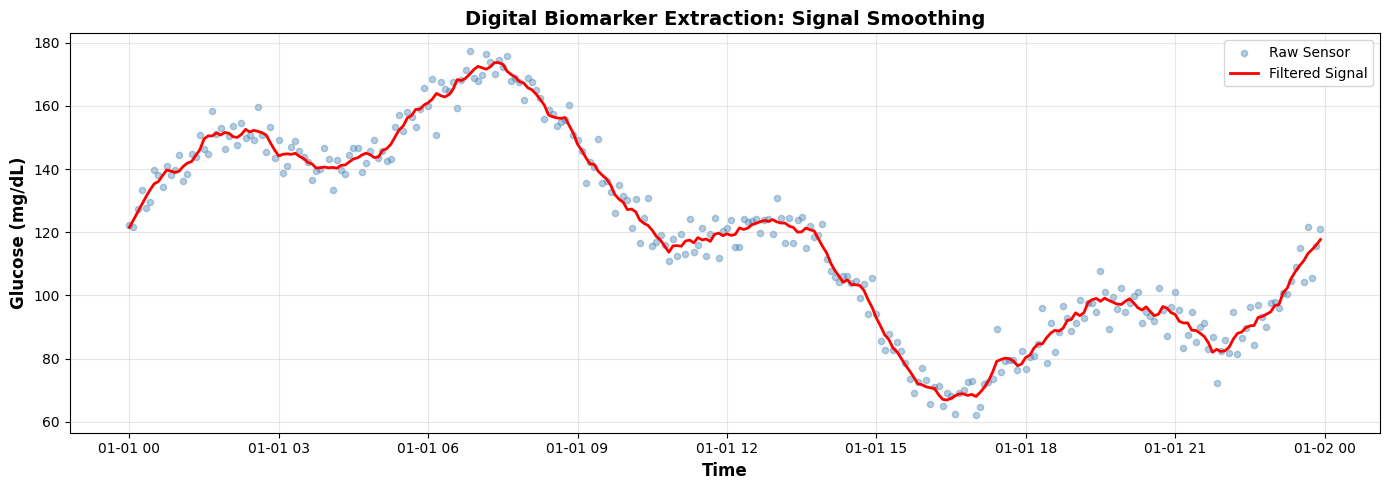

In [33]:
# window_length must be odd. 11 samples = 55 minutes of data.
df['glucose_smooth'] = savgol_filter(df['glucose_raw'], window_length=11, polyorder=3)

# Visualizing the "Clean" vs "Noisy" Signal using Matplotlib (GitHub-compatible)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 5))
ax.scatter(df['timestamp'][:288], df['glucose_raw'][:288], 
           alpha=0.4, s=20, label='Raw Sensor', color='steelblue')
ax.plot(df['timestamp'][:288], df['glucose_smooth'][:288], 
        color='red', linewidth=2, label='Filtered Signal')
ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Glucose (mg/dL)', fontsize=12, fontweight='bold')
ax.set_title('Digital Biomarker Extraction: Signal Smoothing', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1.2 Signal Smoothing and Visualization

Here, we apply the Savitzky-Golay filter to denoise the raw CGM signal while preserving physiological features. This is a critical step for clinical-grade analytics, as it reduces false alarms and improves the reliability of downstream digital biomarkers.

**Clinical Relevance:**
- Smoother signals reduce alarm fatigue for patients and clinicians.
- Preserving true glucose excursions is essential for accurate hypoglycemia prediction.

**Visualization:**
- The plot below compares raw sensor data to the filtered signal, highlighting the effectiveness of the denoising process.


In [34]:
def extract_biomarkers(df):
    # Calculate Velocity (1st Derivative) - mg/dL per minute
    # Since intervals are 5 mins, we divide diff() by 5
    df['velocity'] = df['glucose_smooth'].diff() / 5
    
    # Calculate Acceleration (2nd Derivative) - change in velocity
    df['acceleration'] = df['velocity'].diff() / 5
    
    # Rolling Volatility - SD over 1 hour (12 data points)
    # High volatility = unstable metabolism
    df['volatility_1h'] = df['glucose_smooth'].rolling(window=12).std()
    
    # Metabolic Memory (Lags)
    # Providing context of what happened 15, 30, and 60 minutes ago
    df['lag_15m'] = df['glucose_smooth'].shift(3)
    df['lag_30m'] = df['glucose_smooth'].shift(6)
    df['lag_60m'] = df['glucose_smooth'].shift(12)
    
    # PREDICTION TARGET: What will the glucose be 30 minutes in the future?
    # We shift backward (-6 intervals) to align current features with future results
    df['target_30min'] = df['glucose_smooth'].shift(-6)
    
    return df.dropna()

df_biomarkers = extract_biomarkers(df)
print(f"Biomarker matrix created with {df_biomarkers.shape[1]} features and {len(df_biomarkers)} observations.")

Biomarker matrix created with 10 features and 846 observations.


## 1.3 Feature Engineering: Digital Biomarker Extraction

In this step, we extract clinically meaningful features from the smoothed CGM signal. These digital biomarkers—velocity, acceleration, volatility, and lags—capture the metabolic dynamics necessary for robust hypoglycemia prediction.

**Clinical Relevance:**
- Velocity and acceleration reflect the rate and direction of glucose change, critical for early warning systems.
- Volatility quantifies metabolic instability, which can signal increased risk.
- Lag features provide temporal context, mimicking how clinicians interpret trends over time.

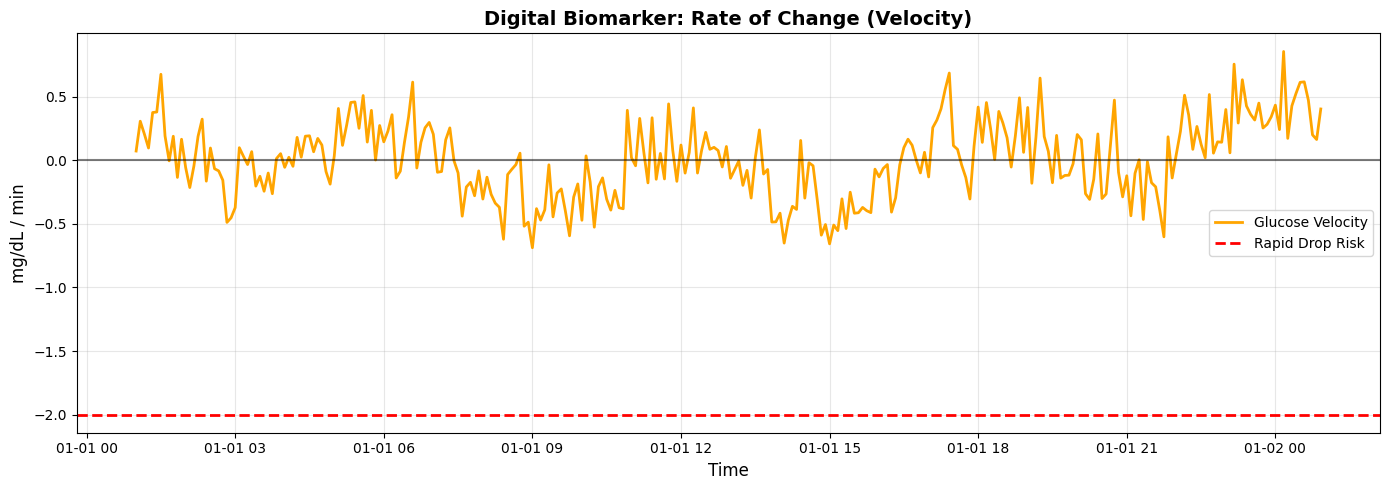

In [35]:
fig_vel, ax = plt.subplots(figsize=(14, 5))

# Plot Velocity
ax.plot(df_biomarkers["timestamp"][:288], df_biomarkers["velocity"][:288], 
        color="orange", linewidth=2, label="Glucose Velocity")

# Add a "Danger Zone" threshold (e.g., falling faster than 2mg/dL per min)
ax.axhline(y=-2.0, linestyle="--", color="red", linewidth=2, label="Rapid Drop Risk")
ax.axhline(y=0, color="black", alpha=0.5)

ax.set_title("Digital Biomarker: Rate of Change (Velocity)", fontsize=14, fontweight="bold")
ax.set_ylabel("mg/dL / min", fontsize=12)
ax.set_xlabel("Time", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1.4 Visualizing Digital Biomarkers

Visualization of engineered features, such as glucose velocity, provides both technical and clinical insight. Here, we plot the rate of change in glucose and highlight thresholds that may indicate rapid drops—critical for hypoglycemia risk assessment.

**Clinical Relevance:**
- Visualizing velocity helps identify periods of rapid glucose decline, supporting proactive intervention.
- Thresholds (e.g., -2 mg/dL/min) can be aligned with clinical guidelines or expert input.

In [36]:
# Save to the correct data folder in GuardianCGM
import os

# Use absolute path from current notebook location
output_dir = 'data'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'processed_biomarkers.csv')
df_biomarkers.to_csv(output_path, index=False)
print(f"Data exported to {output_path}")
print(f"Shape: {df_biomarkers.shape}")

Data exported to data/processed_biomarkers.csv
Shape: (846, 10)


## 1.5 Exporting the Feature Matrix

The final biomarker matrix is exported as a CSV file for use in model training. This step ensures reproducibility and a clear separation between data engineering and modeling. The exported file can be versioned and shared for clinical validation or regulatory review.

**Key Points:**
- Data is saved in a dedicated `data` folder within the project structure.
- The matrix includes all engineered features and the 30-minute prediction target.
- This modular approach supports traceability and compliance in MedTech workflows.

**Best Practice:**
- Maintain clear documentation and version control for all data exports and transformations.
- This approach aligns with pharma and MedTech requirements for traceability and auditability.

---

## 1.6 Key Takeaways & Next Steps

**Key Takeaways:**
- High-quality signal processing and feature engineering are the foundation for clinically robust predictive models.
- The Savitzky-Golay filter effectively denoises CGM data while preserving physiological features.
- Engineered digital biomarkers (velocity, acceleration, volatility, lags) capture the metabolic dynamics necessary for accurate prediction.
- All steps are documented for reproducibility, auditability, and regulatory review.
- The exported feature matrix is ready for model training and clinical validation in the next module.

**Next Steps:**
- Proceed to Module 02 for model training and clinical validation.
- Evaluate model performance using industry-standard metrics (RMSE, R², Clarke Error Grid).
- Implement explainability tools (SHAP) for regulatory transparency.

---

**References:**
- Savitzky, A., & Golay, M. J. E. (1964). Smoothing and Differentiation of Data by Simplified Least Squares Procedures. *Analytical Chemistry*, 36(8), 1627-1639.
- [Savitzky-Golay Filtering in Clinical Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/)
- [Digital Biomarkers in Diabetes](https://www.nature.com/articles/s41746-019-0190-4)
- [FDA Guidance on Data Integrity](https://www.fda.gov/media/119267/download)